In [ ]:
# Image Loading and Preprocessing

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:00<00:00, 120MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [ ]:
import os
import cv2
import glob
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def load_images(directory):
  images = []
  labels = []
  for label, emotion in enumerate(os.listdir(directory)):
    emotion_path = os.path.join(directory, emotion)
    if not os.path.isdir(emotion_path):
      continue # Skip if not a directory
    for filename in glob.glob(os.path.join(emotion_path, "*.jpg")):
      img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) # Convert to grayscale
      img = cv2.resize(img, (48, 48))  # Resize
      img_vector = img.flatten() / 255.0 # Flatten + Normalize
      images.append(img_vector)
      labels.append(label)
  return np.array(images), np.array(labels)

# Define dataset directories
train_dir = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train" #path to our train dataset
test_dir = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test" #path to our test dataset

# Load images and labels
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)


# DATA SPLITTING

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images,
    train_labels,
    test_size=0.2,
    stratify = train_labels,
    random_state=42
)

# train_images, train_labels - are your training data and labels
# val_images, val_labels - are your validation data and labels
# test_images, test_labels - are your test data and labels

# Standardization
scaler = StandardScaler()
train_images= scaler.fit_transform(train_images)
val_images = scaler.transform(val_images)
test_images= scaler.transform(test_images)


In [ ]:
# Exploratory Data Analysis (EDA)

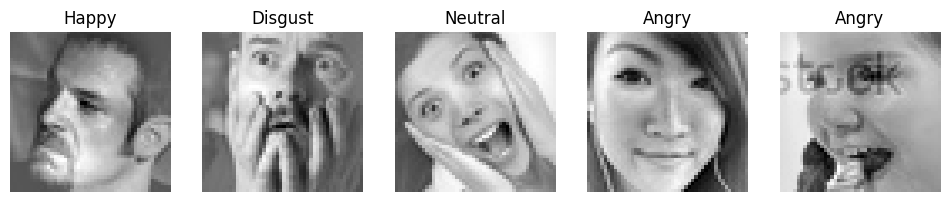

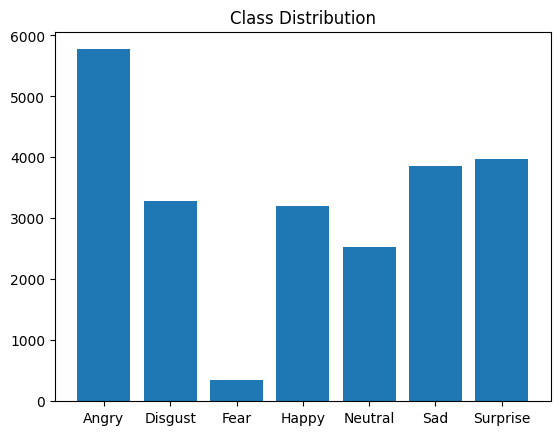

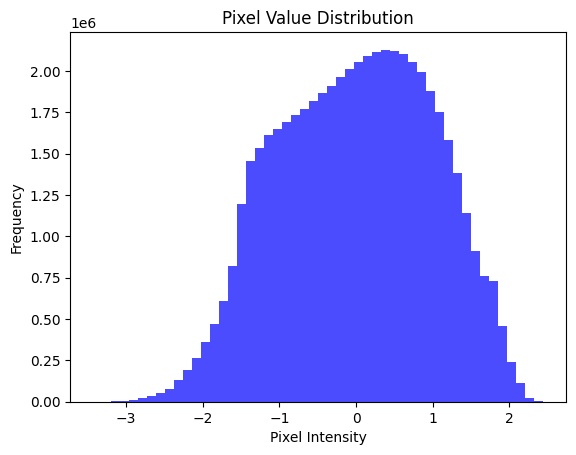

In [ ]:
import matplotlib.pyplot as plt

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

def display_images(images, labels, num_images=5):
  fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
  for i in range(num_images):
    idx = np.random.randint(0, len(images))
    img = images[idx].reshape(48, 48) # Reshape back to 2D
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_names[labels[idx]])
    axes[i].axis('off')
  plt.show()

display_images(train_images, train_labels)

# Class Distribution Bar Chart
unique, counts = np.unique(train_labels, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique, class_names)
plt.title('Class Distribution')
plt.show()

# Pixel Histogram
plt.hist(train_images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Saving the files
np.save("train_images.npy", train_images)
np.save("train_labels.npy", train_labels)
np.save("val_images.npy", val_images)
np.save("val_labels.npy", val_labels)
np.save("test_images.npy", test_images)
np.save("test_labels.npy", test_labels)

In [ ]:
import numpy as np

# Load the data
X_train = np.load("train_images.npy")
y_train = np.load("train_labels.npy")
X_val = np.load("val_images.npy")
y_val = np.load("val_labels.npy")
X_test = np.load("test_images.npy")
y_test = np.load("test_labels.npy")

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint
import joblib
import kagglehub
from google.colab import drive, files  # <--- ADDED: Import drive and files

# Mount Google Drive 
drive.mount('/content/drive')

# 2. Define model_path 
drive_path = '/content/drive/MyDrive/emotion_models' model_filename = 'best_decision_tree_model.pkl'
model_path = os.path.join(drive_path, model_filename)

# Create the directory in Drive if it doesn't exist os.makedirs(drive_path, exist_ok=True)

# Download and Prepare Data
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

def load_images(directory):
    images = []
    labels = []
    for label, emotion in enumerate(os.listdir(directory)):
        emotion_path = os.path.join(directory, emotion)
        if not os.path.isdir(emotion_path):
            continue
        for filename in glob.glob(os.path.join(emotion_path, "*.jpg")):
            img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not read image {filename}")
                continue
            img = cv2.resize(img, (48, 48))
            img_vector = img.flatten() / 255.0
            images.append(img_vector)
            labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# --- 4. Train and Evaluate Baseline Decision Tree ---
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_val_pred = dt_model.predict(X_val)
print(f"Decision Tree (Baseline) Accuracy: {accuracy_score(y_val, y_val_pred)}")
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

# --- 5. Hyperparameter Tuning ---
param_distributions = {
    'max_depth': randint(2, 15),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}

randomized_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

randomized_search.fit(X_train, y_train)
print("Best Decision Tree Parameters:", randomized_search.best_params_)
best_dt_model = randomized_search.best_estimator_
print(f"Best Decision Tree Cross-Validated Accuracy: {randomized_search.best_score_}")

val_accuracy = best_dt_model.score(X_val, y_val)
print(f"Best Decision Tree Accuracy on Validation Set: {val_accuracy}")
print(classification_report(y_val, best_dt_model.predict(X_val)))
print(confusion_matrix(y_val, best_dt_model.predict(X_val)))

test_accuracy = best_dt_model.score(X_test, y_test)
print(f"Best Decision Tree Accuracy on Test Set: {test_accuracy}")
print(classification_report(y_test, best_dt_model.predict(X_test)))
print(confusion_matrix(y_test, best_dt_model.predict(X_test)))

# --- 6. Save to Google Drive AND Download ---
try:
    joblib.dump(best_dt_model, model_path)
    print(f"Model saved to Google Drive: {model_path}")
except Exception as e:
    print(f"ERROR saving to Google Drive: {e}")
    # import sys  # Uncomment if you want to exit on save failure
    # sys.exit(1)

try:
    files.download(model_path)
    print("Model downloaded to local computer.")
except Exception as e:
    print(f"ERROR downloading model: {e}")
    print("You should still have a copy in your Google Drive.")

Mounted at /content/drive
Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1
Decision Tree (Baseline) Accuracy: 0.306687565308255
              precision    recall  f1-score   support

           0       0.40      0.39      0.39      1443
           1       0.26      0.27      0.26       820
           2       0.21      0.24      0.23        87
           3       0.21      0.21      0.21       799
           4       0.43      0.48      0.45       634
           5       0.24      0.23      0.24       966
           6       0.27      0.26      0.27       993

    accuracy                           0.31      5742
   macro avg       0.29      0.30      0.29      5742
weighted avg       0.31      0.31      0.31      5742

[[562 173  13 195  86 202 212]
 [145 220  12  86  95 139 123]
 [ 12  15  21   9   6  11  13]
 [170 115  14 166  73 141 120]
 [ 82  68   8  55 306  59  56]
 [202 143  11 130  77 227 176]
 [230 116  19 137  75 157 259]]
Fitting 3 folds for eac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded to local computer.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Define the best parameters manually
best_dt_model = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=4,
    criterion='entropy',
    random_state=42
)

# 2. Train the model on training data
best_dt_model.fit(X_train, y_train)

# 3. Make predictions on the validation set
y_val_pred_best_dt = best_dt_model.predict(X_val)

# 4. Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred_best_dt)
print(f"Best Decision Tree Accuracy on Validation Set: {accuracy}")

print("Classification Report:\n", classification_report(y_val, y_val_pred_best_dt))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_best_dt))

# 5. Evaluate on the test set
y_test_pred_best_dt = best_dt_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred_best_dt)
print(f"Best Decision Tree Accuracy on Test Set: {test_accuracy}")

Best Decision Tree Accuracy on Validation Set: 0.30912574016022293
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.32      0.29       993
           1       0.00      0.00      0.00        87
           2       0.22      0.11      0.15       820
           3       0.23      0.25      0.24       966
           4       0.24      0.10      0.14       799
           5       0.38      0.38      0.38       634
           6       0.37      0.56      0.45      1443

    accuracy                           0.31      5742
   macro avg       0.25      0.25      0.24      5742
weighted avg       0.29      0.31      0.29      5742

Confusion Matrix:
 [[315   0  45 181  40  51 361]
 [ 12   0   8  12   4   5  46]
 [155   0  89 180  53 107 236]
 [218   0  65 240  54  66 323]
 [153   0  62 169  81  79 255]
 [ 99   0  60  68  31 244 132]
 [231   0  69 174  76  87 806]]
Best Decision Tree Accuracy on Test Set: 0.3110894399554193


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# random forest

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_val_pred_rf = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred_rf)
print(f"Random Forest Accuracy: {accuracy}")
		#proportion of correctly classified examples
print(classification_report(y_val, y_val_pred_rf))
print(confusion_matrix(y_val, y_val_pred_rf))
		#true positive, tn, fp, fn

#Get precision (TP/(TP + FP)), recall (TP/(TP + FN)
precision = precision_score(y_val, y_val_pred_rf)
recall = recall_score(y_val, y_val_pred_rf)
#F1-score (2*(Precision*Recall)/(Precision+Recall))
f1 = f1_score(y_val, y_val_pred_rf)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 8, 12],
    'min_samples_leaf': [2, 4, 6],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV for hyperparameter tuning
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

# Best parameters found
print('Best parameters: ', grid.best_params_)


# Set hyperparameters
'''
rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees in the forest
    max_depth=10,          # Maximum depth of each tree
    min_samples_leaf=2,    # Minimum samples required in a leaf node
    random_state=42
)
'''


Random Forest Accuracy: 0.4437478230581679
              precision    recall  f1-score   support

           0       0.40      0.38      0.39       993
           1       1.00      0.25      0.40        87
           2       0.44      0.28      0.34       820
           3       0.36      0.36      0.36       966
           4       0.46      0.17      0.25       799
           5       0.66      0.55      0.60       634
           6       0.44      0.75      0.55      1443

    accuracy                           0.44      5742
   macro avg       0.54      0.39      0.41      5742
weighted avg       0.46      0.44      0.42      5742

[[ 382    0   61  145   27   19  359]
 [  10   22    5    7    3    4   36]
 [ 104    0  229  145   44   69  229]
 [ 164    0   59  348   39   28  328]
 [ 108    0   71  143  137   33  307]
 [  66    0   49   41   14  349  115]
 [ 114    0   46  139   34   29 1081]]


NameError: name 'precision_score' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Define the best parameters manually
best_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=2,
    random_state=42
)

# 2. Train the model on training data
best_rf_model.fit(X_train, y_train)

# 3. Make predictions on the validation set
y_val_pred_best_rf = best_rf_model.predict(X_val)

# 4. Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred_best_rf)
print(f"Best Random Forest Accuracy on Validation Set: {accuracy}")

print("Classification Report:\n", classification_report(y_val, y_val_pred_best_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_best_rf))

# 5. Evaluate on the test set
y_test_pred_best_rf = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred_best_rf)
print(f"Best Random Forest Accuracy on Test Set: {test_accuracy}")

Best Decision Tree Accuracy on Validation Set: 0.39742250087077674
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.32      0.36       993
           1       1.00      0.02      0.04        87
           2       0.48      0.12      0.19       820
           3       0.32      0.31      0.31       966
           4       0.50      0.07      0.13       799
           5       0.57      0.48      0.52       634
           6       0.38      0.84      0.52      1443

    accuracy                           0.40      5742
   macro avg       0.52      0.31      0.30      5742
weighted avg       0.44      0.40      0.35      5742

Confusion Matrix:
 [[ 316    0   16  149   14   32  466]
 [  10    2    3    8    1    5   58]
 [  88    0   99  144   20   84  385]
 [ 154    0   21  296    9   37  449]
 [  94    0   25  153   58   40  429]
 [  57    0   24   45    7  306  195]
 [  57    0   17  126    6   32 1205]]
Best Random Forest Accurac

In [ ]:
# logistic regression

from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42, max_iter=1000)
# Increase max_iter if needed^
lr_model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

y_val_pred_lr = lr_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy}")
		#proportion of correctly classified examples
print(classification_report(y_val, y_val_pred_lr))
print(confusion_matrix(y_val, y_val_pred_lr))
		#true positive, tn, fp, fn

#Get precision (TP/(TP + FP)), recall (TP/(TP + FN)
precision = precision_score(y_val, y_val_pred_lr, average='weighted')
recall = recall_score(y_val, y_val_pred_lr, average='weighted')
#F1-score (2*(Precision*Recall)/(Precision+Recall))
f1 = f1_score(y_val, y_val_pred_lr, average='weighted')

print(f"Precision (Weighted): {precision}")
print(f"Recall (Weighted): {recall}")
print(f"F1-Score (Weighted): {f1}")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {
    'C': [0.01, 0.1, 1, 10, 100],            # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],   # Type of regularization
    'solver': ['liblinear', 'saga'],         # Solvers supporting penalties
    'max_iter': [100, 200, 500]              # Iterations for convergence
}

randomized_search = RandomizedSearchCV(estimator=lr_model, param_distributions=param_distributions, n_iter=10, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)
randomized_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:", randomized_search.best_params_)

Logistic Regression Accuracy: 0.31539533263671193
              precision    recall  f1-score   support

           0       0.26      0.25      0.26       993
           1       0.13      0.14      0.13        87
           2       0.22      0.19      0.20       820
           3       0.24      0.23      0.23       966
           4       0.23      0.20      0.21       799
           5       0.41      0.44      0.42       634
           6       0.43      0.51      0.47      1443

    accuracy                           0.32      5742
   macro avg       0.28      0.28      0.28      5742
weighted avg       0.31      0.32      0.31      5742

[[252  16 107 171 112  76 259]
 [ 11  12  12  11  14   7  20]
 [132  15 154 138 111 113 157]
 [194  19 115 221 113  70 234]
 [122  11  98 146 159  64 199]
 [ 71   4  76  63  48 280  92]
 [177  14 129 175 138  77 733]]
Precision (Weighted): 0.30503921465362366
Recall (Weighted): 0.31539533263671193
F1-Score (Weighted): 0.30899406534932866
Fitting 2 fol

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

knn_model = KNeighborsClassifier()
y_val = knn_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred_knn)
print(f"K Nearest Neighbors Accuracy: {accuracy}")
		#proportion of correctly classified examples
print(classification_report(y_val, y_val_pred_knn))
print(confusion_matrix(y_val, y_val_pred_knn))
		#true positive, tn, fp, fn

#Get precision (TP/(TP + FP)), recall (TP/(TP + FN)
precision = precision_score(y_val, y_val_pred_knn, average='weighted')
recall = recall_score(y_val, y_val_pred_knn, average='weighted')
#F1-score (2*(Precision*Recall)/(Precision+Recall))
f1 = f1_score(y_val, y_val_pred_knn, average='weighted')

print(f"Precision (Weighted): {precision}")
print(f"Recall (Weighted): {recall}")
print(f"F1-Score (Weighted): {f1}")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Hyperparameter distribution
param_distributions = {
    'n_neighbors': [3, 5, 7, 10],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

randomized_search = RandomizedSearchCV(estimator=knn_model, param_distributions=param_distributions, n_iter=10, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
randomized_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:", randomized_search.best_params_)


# Set hyperparameters
'''
knn_model = KNeighborsClassifier(
    n_neighbors=7,
    metric='manhattan'
)
'''



NameError: name 'knn_model' is not defined

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Define the best parameters manually
best_knn_model = KNeighborsClassifier(
    n_neighbors=7,
    metric='manhattan'
)

# 2. Train the model on training data
best_knn_model.fit(X_train, y_train)

# 3. Make predictions on the validation set
y_val_pred_best_knn = best_knn_model.predict(X_val)

# 4. Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred_best_knn)
print(f"Best KNN Accuracy on Validation Set: {accuracy}")

print("Classification Report:\n", classification_report(y_val, y_val_pred_best_knn))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_best_knn))

# 5. Evaluate on the test set
y_test_pred_best_knn = best_knn_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred_best_knn)
print(f"Best KNN Accuracy on Test Set: {test_accuracy}")

Best KNN Accuracy on Validation Set: 0.33611981887843956
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.50      0.34       993
           1       0.29      0.24      0.26        87
           2       0.29      0.26      0.28       820
           3       0.30      0.22      0.26       966
           4       0.33      0.17      0.23       799
           5       0.46      0.35      0.39       634
           6       0.44      0.43      0.44      1443

    accuracy                           0.34      5742
   macro avg       0.34      0.31      0.31      5742
weighted avg       0.35      0.34      0.33      5742

Confusion Matrix:
 [[498   6  99 100  56  41 193]
 [ 26  21  10   5   4   3  18]
 [246   9 213  86  49  80 137]
 [340  10 127 214  59  33 183]
 [257   6  97 106 137  39 157]
 [153   5  76  42  34 220 104]
 [403  16 101 156  74  66 627]]


In [ ]:
# decision tree accuracy on test set: 0.3110894399554193
# random forest accuracy on test set: 0.40596266369462247
# logistic regression accuracy on test set:
# knn accuracy on test set:

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_test = test_labels

# 2. Select the BEST model after hyperparameter tuning
best_model = best_rf_model

# 3. Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# 4. Evaluate performance
print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
